<h1 align=center><font size = 5>Data Science and Machine Learning Capstone Project</font></h1>

### Question 4. Can a predictive model be built for future prediction of the possibility of complaints of the specific type that you identified in response to Question 1? ### 

I will use **FFT**, **SARIMA** and **LSTM** models to predict the number of future complaint of specific type identified in Q1, which is HEAT/HOT Water, based on month and then decide based on the performance of these model whether such a model described in the question can be built. The reason I choose month as the time measure is just to make it more simple. 

***<font size = 4>Data preparation</font>***

Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import statsmodels.api as sm
import pmdarima as pm

Import the data.

In [2]:
columns_used1 = ['complaint_type', 'created_date'] 
df_311= pd.read_csv('fhrw-4uyv.csv', usecols = columns_used1, parse_dates = ['created_date'])
df_311.head()

,complaint_type,created_date
0,APPLIANCE,2016-12-05 16:13:38
1,DOOR/WINDOW,2016-12-05 20:43:42
2,DOOR/WINDOW,2016-12-05 14:59:24
3,DOOR/WINDOW,2016-12-05 16:40:33
4,SAFETY,2016-12-05 07:57:43


Select all rows with HEAT/HOT WATER as the complaint type

In [3]:
df_311 = df_311[df_311['complaint_type'] == 'HEAT/HOT WATER']

Create time series data with month based of HEAT/HOT WATER complaint 

In [4]:
time_ser_HH_compt = pd.Series(1, index = df_311['created_date'])
time_ser_HH_compt = time_ser_HH_compt.resample('M').sum()
time_ser_HH_compt.head(10)

created_date
2014-03-31    14462
2014-04-30    13382
2014-05-31     4262
2014-06-30     2747
2014-07-31     2490
2014-08-31     2163
2014-09-30     2368
2014-10-31    16733
2014-11-30    42458
2014-12-31    31702
Freq: M, dtype: int64

Lets check the last rows of the time series and the number of data.

In [5]:
time_ser_HH_compt.tail()

created_date
2018-10-31    26642
2018-11-30    35189
2018-12-31    29251
2019-01-31    47087
2019-02-28    16185
Freq: M, dtype: int64

Remove the last row, because at the time when the data was downloaded, the data was gathered until the middle February 2019. Thus, the data at February, 2019 is not recorded for the whole month.

In [6]:
# remove the last row
time_ser_HH_compt.drop(labels = time_ser_HH_compt.index[-1], inplace = True)

In [7]:
time_ser_HH_compt.tail()

created_date
2018-09-30     2716
2018-10-31    26642
2018-11-30    35189
2018-12-31    29251
2019-01-31    47087
Freq: M, dtype: int64

In [8]:
time_ser_HH_compt.shape

(59,)

Next, lets plot the time series data.

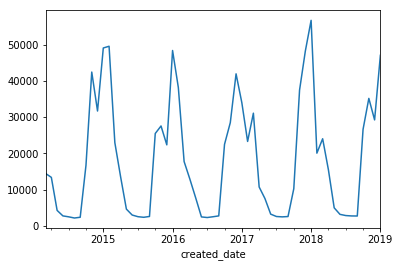

In [9]:
time_ser_HH_compt.plot(kind='line')

We see pattern from the data, there is a periodicity, where there is a high number of complaint around winter season and low number of complaint at summer season. The time series began at March, 2014 and end at January, 2019, which is around 5 years time period. 

The range of data values seems too big, so lets scaled down the data to the range of (0, 100) with MinMaxScaler.

In [10]:
scaler = MinMaxScaler(feature_range = (0, 100)).fit(time_ser_HH_compt.values.reshape(-1,1))
Scaled_ser = scaler.transform(time_ser_HH_compt.values.reshape(-1,1))
Scaledtime_ser_HH_compt = pd.Series(Scaled_ser.reshape(-1,))
Scaledtime_ser_HH_compt.head()

/home/hadji-mufushi/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


0    22.535134
1    20.556278
2     3.845942
3     1.070048
4     0.599153
dtype: float64

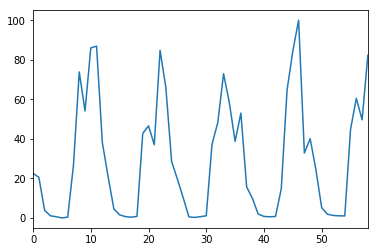

In [11]:
Scaledtime_ser_HH_compt.plot(kind='line')

Before we create the models, we need to split the data into train and test set. Lets choose the last 11 as the test set for model performance validation and the rest for the train set.

In [12]:
Train_set =  Scaledtime_ser_HH_compt[:len(Scaledtime_ser_HH_compt)-11]
# keep the test set with real value
Test_set = time_ser_HH_compt[len(Scaledtime_ser_HH_compt)-11:]

Next, lets do the modeling.

### The models ### 

***<font size = 3>0. The persistence model</font>***

First, lets create the persistence model as the baseline performance. The model performance will be measured using root means squared error(RMSE).

In [13]:
real_data = time_ser_HH_compt[48:]
prediction =  time_ser_HH_compt[47:58]

# RMSE score
score =  sqrt(mean_squared_error(real_data, prediction))
print("Persistence model score: ", score)

Persistence model score:  10452.477857600865


***<font size = 3>1. The FFT(Fast Fourier Transform) model</font>***

Next, lets try FFT model. There are some  conditions need to be fullfiled for FFT model, which are that there is periodicity in the data, and it needs to be stationary (not need to be point by point, but at least period by period).

In [14]:
# Number of trained data
N = len(Train_set)
# Do FFT
fft_Train_set = np.fft.fft(Train_set)
# Calculate the frequency
freq = np.fft.fftfreq(N)
# Calculate the amplitude
Amp = np.abs(fft_Train_set)/N
# Calculate the phase
Phase = np.angle(fft_Train_set)

Lets plot the amplitude vs frequency.

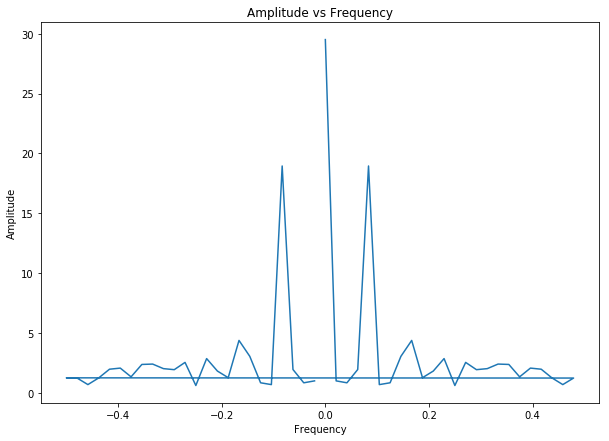

In [15]:
plt.figure(figsize=(10,7))
plt.plot(freq, Amp)
plt.title('Amplitude vs Frequency')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()

Filter the functions with these criteria:
 <ul>
  <li>Amplitude more than 3</li>
  <li>Frequency between 0 and 0.3</li>
</ul> 

In [16]:
# filtering amplitude, frequency and phase
filter_ = np.logical_or(np.logical_and(freq >= 0, freq < 0.3), Amp > 3)
filtered_freq = freq[filter_]
filtered_amp = Amp[filter_]
filtered_phase = Phase [filter_]

Create model function.

In [17]:
def func_model(x, amplitude, phase, freq):
    a = []
    for i in x:
        f = np.cos(2*np.pi*freq*i + phase)
        a.append(np.dot(amplitude, f))
    return np.array(a)

Make predictions for time series index 0 to 59 (Note that there are 60 point predictions).

In [18]:
index_series = np.arange(48, 59, 1)
predictions1 = func_model(index_series, filtered_amp, filtered_phase, filtered_freq )
predictions1_inverted = scaler.inverse_transform(predictions1.reshape(-1,1))

Plot the real data vs prediction values.

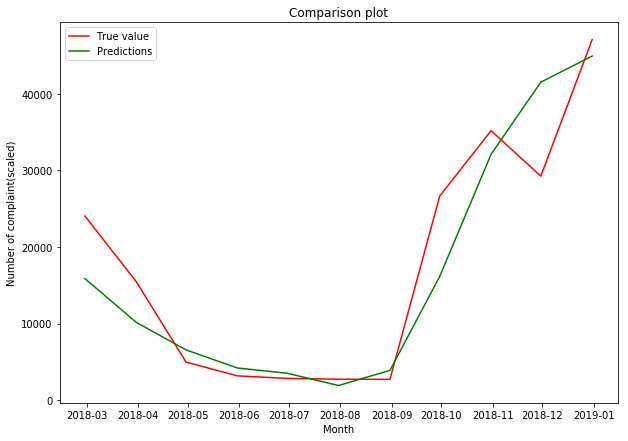

In [47]:
predict_date_range = pd.date_range(start='2/1/2018', end='1/1/2019', freq='M')
plt.figure(figsize=(10,7))
plt.plot(predict_date_range, Test_set, color = 'r', label = 'True value')
plt.plot(predict_date_range, predictions1_inverted, color = 'g', label = 'Predictions')
plt.title('Comparison plot')
plt.xlabel('Month')
plt.ylabel('Number of complaint(scaled)')
plt.legend()
plt.show()

We see that the model could track the pattern.

Now lets calculate the performance score of the FFT model.

In [20]:
# calculate RMSE score
score =  sqrt(mean_squared_error(Test_set, predictions1_inverted))
print("FFT model score: ", score)

FFT model score:  5845.825349055646


***<font size = 3>2. SARIMA model</font>***

Sarima model have parameter (p, d, q)x(P, D, Q)m that need to be tuned to find the best model, it will be tedious to use some analysis using ACF and PACF to find these parameters. Instead, lets automate this process using pmdarima.auto_arima. 

In [24]:
# fit stepwise auto-ARIMA, choose m = 12, since the seasonal pattern occurs every 12 month
stepwise_fit = pm.auto_arima(Train_set, start_p=0, d=0, start_q=0,
                             max_p=12, max_d= 2, max_q=12,
                             start_P=0, D=0, start_Q=0, seasonal=True,
                             max_P=3, max_D=2, max_Q=3,
                             max_order = None, m=12, trace=False,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=False)  # set to stepwise

In [25]:
# Check best model summary 
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:               SARIMAX(2, 0, 3)   Log Likelihood                -198.210
Date:                Mon, 08 Apr 2019   AIC                            410.420
Time:                        12:27:28   BIC                            423.519
Sample:                             0   HQIC                           415.370
                                 - 48                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      7.9541      0.677     11.741      0.000       6.626       9.282
ar.L1          1.7333      0.006    276.576      0.000       1.721       1.746
ar.L2         -1.0000      0.001  -1605.683      0.000      -1.001      -0.999
ma.L1         -1.7120      0.272     -6.295      0.000      -2.245      -1.179
ma.L2          0.9764      0.418      2.333      0.020       0.156       1.797
ma.L3          0.0127      0.163      0.078      0.938      -0.307       0.332
sigma2       184.1252      0.003   5.38e+04      0.000     184.118     184.132
===================================================================================
Ljung-Box (Q):                       36.30   Jarque-Bera (JB):                 0.81
Prob(Q):                              0.64   Prob(JB):                         0.67
Heteroskedasticity (H):               1.32   Skew:                             0.30
Prob(H) (two-sided):                  0.59   Kurtosis:                         2.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.9e+20. Standard errors may be unstable.
"""

The auto_arima choose (2, 0, 3)x(0, 0, 0)12 as the best model parameter i.e it turns out that ARMA is the best model. Next, lets create model and make predictions.

In [21]:
# create SARIMA model
model = sm.tsa.statespace.SARIMAX(Train_set, order=(2,0,3), seasonal_order=(0,0,0,12), trend = 'c')
model_fit = model.fit()

/home/hadji-mufushi/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [22]:
# calculate predictions by the SARIMA model
predictions2 = model_fit.predict(start=48, end=58, dynamic=False)
# since it is imposible for the number of complaint to be negative, lets take the negative predictions into 0 
predictions2[predictions2 < 0] = 0
predictions2_inverted = scaler.inverse_transform(predictions2.values.reshape(-1, 1))

Plot the real data vs prediction values.

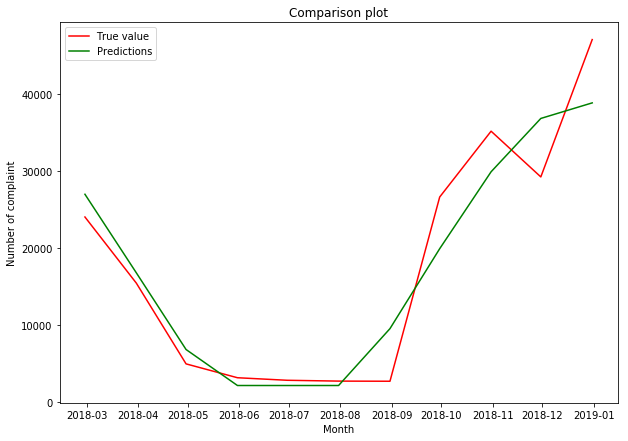

In [48]:
plt.figure(figsize=(10,7))
plt.plot(predict_date_range, Test_set, color = 'r', label = 'True value')
plt.plot(predict_date_range, predictions2_inverted, color = 'g', label = 'Predictions')
plt.title('Comparison plot')
plt.xlabel('Month')
plt.ylabel('Number of complaint')
plt.legend()
plt.show()

Calculate the performance score of SARIMA model.

In [24]:
score = sqrt(mean_squared_error(Test_set, predictions2_inverted))
print('SARIMA model score: ', score )

SARIMA model score:  4866.659926315047


We see there is an improvement from the previous model. Next, lets try LSTM model.

***<font size = 3>3. LSTM model</font>***

***<font size = 4>Preprocessing data</font>***

First, we need to prepare the data, so that it can be processed as an input for the LSTM layer by change the data dimension into (n_sample, n_step, n_features) and separate it into train and test set.

In [25]:
# change data into np.array
data_series = Scaledtime_ser_HH_compt.values

Define a split sequence function to spilt the series into multiple series and its label/next number of the sequence.

In [26]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
    # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [27]:
# set the time step
n_steps = 10
#split the series into multiple sequence
X, y = split_sequence(data_series, n_steps)

In [28]:
# Split the sequences of data into train and test set
# As before, we take the last 11 data as the test set
X_train, y_train = X[:len(X)-11], y[:len(X)-11]
X_test, y_test = X[len(X)-11:], y[len(X)-11:]

In [29]:
# Reshape the dimension of train and test feature set into (n_sample, n_step, n_features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))  

***<font size = 4>Create and train model</font>***

Now, lets create the LSTM model using keras library.

In [1]:
# import the necessary library
from keras.models import Sequential  
from keras.layers import Dense, LSTM, Dropout  
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
# define model
def TS_model():
    
    model = Sequential()  
    model.add(LSTM(units=50, input_shape=(n_steps, 1), activation = 'relu', return_sequences=True))  
    model.add(Dropout(0.1))
    
    model.add(LSTM(units=50, activation = 'relu'))  
    model.add(Dropout(0.1))
      
    model.add(Dense(units = 1))  
    
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    return model

In [3]:
# set the callback functions
earlyStopping = EarlyStopping(monitor='val_loss', patience=500, verbose=0, mode='min')
mcp_save = ModelCheckpoint('lstm_time_series.hdf5', save_best_only=True, 
                           monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=200, verbose=1, min_delta=1e-4, mode='min')

In [20]:
# create model and do training
model = TS_model()
model.fit(X_train, y_train, epochs = 1000, validation_data = (X_test, y_test), 
          batch_size = 38, verbose = 2, callbacks=[earlyStopping, mcp_save, reduce_lr_loss])  

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 38 samples, validate on 11 samples
Epoch 1/1000
 - 1s - loss: 1953.6731 - val_loss: 1516.5027
Epoch 2/1000
 - 0s - loss: 1900.8865 - val_loss: 1484.0140
Epoch 3/1000
 - 0s - loss: 1866.0707 - val_loss: 1454.7860
Epoch 4/1000
 - 0s - loss: 1840.2568 - val_loss: 1427.1813
Epoch 5/1000
 - 0s - loss: 1799.3756 - val_loss: 1400.0294
Epoch 6/1000
 - 0s - loss: 1781.2181 - val_loss: 1372.2715
Epoch 7/1000
 - 0s - loss: 1759.0140 - val_loss: 1344.0419
Epoch 8/1000
 - 0s - loss: 1738.6840 - val_loss: 1313.8867
Epoch 9/1000
 - 0s - loss: 1682.1143 - val_loss: 1281.3958
Epoch 10/1000
 - 0s - loss: 1679.2166 - val_loss: 1245.2267
Epoch 11/1000
 - 0s - loss: 1615.1957 - val_loss: 1203.9894
Epoch 12/1000
 - 0s - loss: 1585.9525 - val_loss: 1152.4878
Epoch 13/1

 - 0s - loss: 97.0238 - val_loss: 77.2281
Epoch 127/1000
 - 0s - loss: 84.4700 - val_loss: 73.9753
Epoch 128/1000
 - 0s - loss: 86.0423 - val_loss: 77.1016
Epoch 129/1000
 - 0s - loss: 124.7243 - val_loss: 78.5038
Epoch 130/1000
 - 0s - loss: 89.4292 - val_loss: 77.7518
Epoch 131/1000
 - 0s - loss: 78.0967 - val_loss: 80.9119
Epoch 132/1000
 - 0s - loss: 40.2150 - val_loss: 84.1561
Epoch 133/1000
 - 0s - loss: 79.7950 - val_loss: 81.6882
Epoch 134/1000
 - 0s - loss: 101.2656 - val_loss: 77.7000
Epoch 135/1000
 - 0s - loss: 109.5415 - val_loss: 75.5675
Epoch 136/1000
 - 0s - loss: 71.5648 - val_loss: 77.9137
Epoch 137/1000
 - 0s - loss: 82.2788 - val_loss: 74.4469
Epoch 138/1000
 - 0s - loss: 61.1036 - val_loss: 68.4264
Epoch 139/1000
 - 0s - loss: 111.6528 - val_loss: 70.4888
Epoch 140/1000
 - 0s - loss: 53.6484 - val_loss: 73.2988
Epoch 141/1000
 - 0s - loss: 83.4587 - val_loss: 72.8751
Epoch 142/1000
 - 0s - loss: 39.8390 - val_loss: 73.7167
Epoch 143/1000
 - 0s - loss: 52.0362 - val

Epoch 269/1000
 - 0s - loss: 99.2640 - val_loss: 97.9124
Epoch 270/1000
 - 0s - loss: 26.5634 - val_loss: 99.5010
Epoch 271/1000
 - 0s - loss: 32.0039 - val_loss: 115.7821
Epoch 272/1000
 - 0s - loss: 30.2781 - val_loss: 135.1309
Epoch 273/1000
 - 0s - loss: 64.9987 - val_loss: 110.9598
Epoch 274/1000
 - 0s - loss: 46.2495 - val_loss: 93.1184
Epoch 275/1000
 - 0s - loss: 20.7872 - val_loss: 87.6931
Epoch 276/1000
 - 0s - loss: 35.4437 - val_loss: 88.4538
Epoch 277/1000
 - 0s - loss: 34.8766 - val_loss: 84.8395
Epoch 278/1000
 - 0s - loss: 59.1957 - val_loss: 77.4618
Epoch 279/1000
 - 0s - loss: 21.4480 - val_loss: 76.6491
Epoch 280/1000
 - 0s - loss: 27.6214 - val_loss: 88.8537
Epoch 281/1000
 - 0s - loss: 20.9512 - val_loss: 97.9677
Epoch 282/1000
 - 0s - loss: 26.9531 - val_loss: 92.9594
Epoch 283/1000
 - 0s - loss: 37.8259 - val_loss: 82.0053
Epoch 284/1000
 - 0s - loss: 38.7020 - val_loss: 84.9907
Epoch 285/1000
 - 0s - loss: 18.7130 - val_loss: 90.2129
Epoch 286/1000
 - 0s - loss:

Epoch 411/1000
 - 0s - loss: 36.5286 - val_loss: 96.6620
Epoch 412/1000
 - 0s - loss: 32.6264 - val_loss: 96.2789
Epoch 413/1000
 - 0s - loss: 29.6940 - val_loss: 95.6558
Epoch 414/1000
 - 0s - loss: 18.3262 - val_loss: 95.2265
Epoch 415/1000
 - 0s - loss: 24.2943 - val_loss: 94.7058
Epoch 416/1000
 - 0s - loss: 22.6552 - val_loss: 94.5539
Epoch 417/1000
 - 0s - loss: 24.7451 - val_loss: 94.5057
Epoch 418/1000
 - 0s - loss: 37.5148 - val_loss: 94.7039
Epoch 419/1000
 - 0s - loss: 16.9738 - val_loss: 95.1138
Epoch 420/1000
 - 0s - loss: 19.4551 - val_loss: 95.3361
Epoch 421/1000
 - 0s - loss: 28.7660 - val_loss: 95.8722
Epoch 422/1000
 - 0s - loss: 16.1021 - val_loss: 96.2987
Epoch 423/1000
 - 0s - loss: 19.4520 - val_loss: 96.9079
Epoch 424/1000
 - 0s - loss: 53.6095 - val_loss: 98.0097
Epoch 425/1000
 - 0s - loss: 15.7629 - val_loss: 99.0180
Epoch 426/1000
 - 0s - loss: 23.4107 - val_loss: 99.4436
Epoch 427/1000
 - 0s - loss: 19.3531 - val_loss: 99.9959
Epoch 428/1000
 - 0s - loss: 59

Epoch 553/1000
 - 0s - loss: 17.2913 - val_loss: 98.5439
Epoch 554/1000
 - 0s - loss: 32.1406 - val_loss: 98.5294
Epoch 555/1000
 - 0s - loss: 25.0160 - val_loss: 98.4817
Epoch 556/1000
 - 0s - loss: 21.8526 - val_loss: 98.4472
Epoch 557/1000
 - 0s - loss: 18.7249 - val_loss: 98.4090
Epoch 558/1000
 - 0s - loss: 37.5814 - val_loss: 98.4288
Epoch 559/1000
 - 0s - loss: 29.2705 - val_loss: 98.4472
Epoch 560/1000
 - 0s - loss: 32.4687 - val_loss: 98.5000
Epoch 561/1000
 - 0s - loss: 19.2925 - val_loss: 98.4884
Epoch 562/1000
 - 0s - loss: 25.7887 - val_loss: 98.4795
Epoch 563/1000
 - 0s - loss: 18.1596 - val_loss: 98.4622
Epoch 564/1000
 - 0s - loss: 21.8323 - val_loss: 98.4164
Epoch 565/1000
 - 0s - loss: 45.9384 - val_loss: 98.3938
Epoch 566/1000
 - 0s - loss: 49.7800 - val_loss: 98.3629
Epoch 567/1000
 - 0s - loss: 40.3521 - val_loss: 98.4016
Epoch 568/1000
 - 0s - loss: 40.3619 - val_loss: 98.4749
Epoch 569/1000
 - 0s - loss: 24.4875 - val_loss: 98.5178
Epoch 570/1000
 - 0s - loss: 11

***<font size = 4>Predict</font>***

Get the best model saved from the training process.

In [31]:
from keras.models import load_model
best_model = load_model('lstm_time_series.hdf5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


***<font size = 3>One time step prediction</font>***

Make one time step predictions for 48th step to 59th step( March, 2018 - January, 2019).

In [32]:
# make predictions
one_predictions3 = best_model.predict(X_test)
# convert the negative predictions into 0 
one_predictions3[one_predictions3 < 0] = 0
one_predictions3_inverted = scaler.inverse_transform(one_predictions3.reshape(-1, 1))
one_predictions3_inverted

array([[22747.799 ],
       [12278.669 ],
       [ 6995.3228],
       [ 2639.571 ],
       [ 3583.7568],
       [ 3310.4917],
       [ 5006.41  ],
       [24087.781 ],
       [29229.95  ],
       [37715.227 ],
       [43778.312 ]], dtype=float32)

Plot the real data vs prediction values.

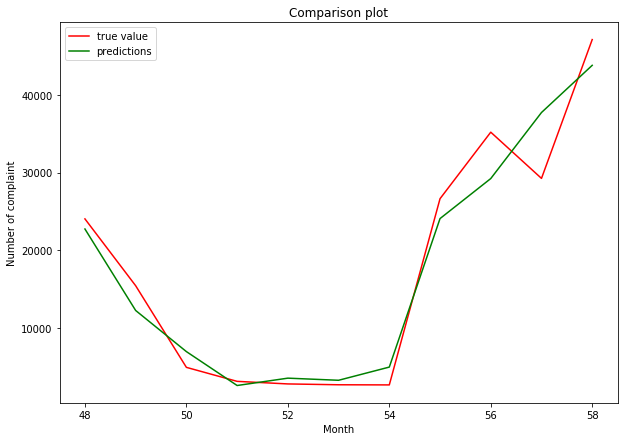

In [49]:
index_series3 = np.arange(48, 59, 1)
plt.figure(figsize=(10,7))
plt.plot(index_series3, Test_set, color = 'r', label = 'true value')
plt.plot(index_series3, one_predictions3_inverted, color = 'g', label = 'predictions')
plt.title('Comparison plot')
plt.xlabel('Month')
plt.ylabel('Number of complaint')
plt.legend()
plt.show()

Check the LSTM model performance score for one time step predictions.

In [62]:
one_score3 = sqrt(mean_squared_error(Test_set, predictions3_inverted))
print('One time step LSTM score: ', one_score3 )

One time step LSTM score:  3654.84959252442


***<font size = 3>Eleven time step prediction</font>***

It is not an eye to eye comparison if we compare the performance of one time step prediction with the performance of previous model, since with the previous model, we do eleven time step prediction. Now lets predict for eleven time step prediction.

In [51]:
# copy the first test sequence
Seq = np.copy(X_test[0].reshape(1, X_test[0].shape[0], 1))
Seq

array([[[  9.8667937 ],
        [  1.955036  ],
        [  0.75489675],
        [  0.57899848],
        [  0.74390311],
        [ 14.81576488],
        [ 64.71957052],
        [ 84.44216428],
        [100.        ],
        [ 32.81418913]]])

In [52]:
# Make eleven time step predictions using the last 10 sequence form Seq added with the last prediction value
# i.e the results of eleven time step predictions is put in the last 11 entry in Seq
for i in range(11):
    prediction = best_model.predict(Seq[0:, i:])
    Seq = np.insert(Seq, len(Seq[0]), [prediction], axis = 1)

In [53]:
Eleven_predictions3_inverted = scaler.inverse_transform(Seq.reshape(-1, 1))
# convert the negative predictions into 0 
Eleven_predictions3_inverted[Eleven_predictions3_inverted < 0]=0
Eleven_predictions3_inverted

array([[ 7548.        ],
       [ 3230.        ],
       [ 2575.        ],
       [ 2479.        ],
       [ 2569.        ],
       [10249.        ],
       [37485.        ],
       [48249.        ],
       [56740.        ],
       [20072.        ],
       [22747.79824589],
       [11149.7506189 ],
       [ 6195.1209202 ],
       [ 3890.65037889],
       [ 2778.23391231],
       [ 1773.87949039],
       [ 5622.33270901],
       [22092.45744003],
       [27453.65918144],
       [34689.93347145],
       [40918.2746022 ]])

Plot the real data vs prediction values.

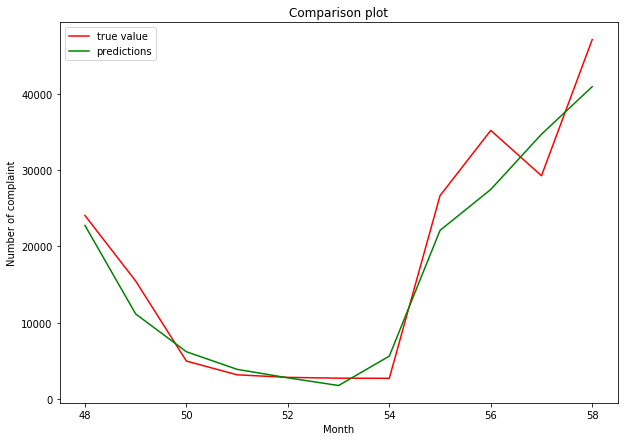

In [54]:
plt.figure(figsize=(10,7))
plt.plot(index_series3, Test_set, color = 'r', label = 'true value')
plt.plot(index_series3, Eleven_predictions3_inverted[10:], color = 'g', label = 'predictions')
plt.title('Comparison plot')
plt.xlabel('Month')
plt.ylabel('Number of complaint')
plt.legend()
plt.show()

Check the LSTM model performance score for eleven time step predictions.

In [55]:
eleven_score3 = sqrt(mean_squared_error(Test_set, Eleven_predictions3_inverted[10:]))
print('Eleven time step LSTM score: ', eleven_score3 )

Eleven time step LSTM score:  4043.1103976973277


***<font size = 5>Conclusion</font>***

We have the performance score of models above as listed below:
<ul>
    <li>Persistence: 10452.478</li>
    <li>FFT: 5845.825</li>
    <li>SARIMA: 4866.660</li>
    <li>LSTM</li>
    <ul>
         <li>One time step: 3654.850</li>
         <li>Eleven time step: 4043.110</li>
    </ul>
</ul>

Using Persistence model as a baseline, we have that FFT, SARIMA and LSTM model perform much better compared to persistence model with a big performance score margin and those three models can make predictions that track the pattern of the time series. Therefore, based on performance of models we see above, I am in the opinion that a model that could predict the number of future complaint of HEAT/HOT WATER can be built.

***<font size = 3>Author : Hadi Muhshi</font>*** 